# Bending energy

I have a hypothesis that the active nematics bend more in slower flowing channels, resulting in more free energy penalty. It would be great if I can do a simulation on a constrained system, to see how the orientation field is optimized. However, since the simulation method is not readily available, I'm going to test this hypothesis on experimental data first. The plan is:

- extract orientational field $p$ from images;
- compute bending energy based on $p$ and the boundaries;
- plot bending energy as a function of flow rate (fraction).

In this notebook, I'm going to develop the method for image analysis, based on the code I got from Claire (originally from A. N.-F.'s lab).

## 0 Packages

In [1]:
import os
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter1d
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

## 1 Filament orientation

Detect the director field from the images. This section main reproduce the code developed in Matlab by Perry W. Ellis (GaTech). The method is described in [a Nature Physics paper](https://www.nature.com/articles/nphys4276#Sec2). The idea is to measure the pixel intensity fluatuations around each pixel at all directions, and then identify the direction with the least fluctuations as the "coherence direction". This coherent direction is determined as the director at that pixel. 

In [216]:
def fndstruct(sigma1, sigma2, im):
    """
    Returns the structure tensor orientation of an image.

    Args:
    sigma1 -- gaussian filter sigma for the raw image.
    sigma2 -- gaussian filter sigma for the gradient fields.
    im -- the input image, [M x N].

    Returns:
    director_field -- the structure tensor orientation, [M x N x 2].
    """
    imgf = gaussian_filter(im, sigma1)

    gx, gy = np.gradient(imgf)

    gxgx = gx * gx
    gxgy = gx * gy
    gygy = gy * gy

    gxgx = gaussian_filter(gxgx, sigma2)
    gxgy = gaussian_filter(gxgy, sigma2)
    gygy = gaussian_filter(gygy, sigma2)

    aa = np.array([[gxgx, gxgy], [gxgy, gygy]])
    eigenvalues, eigenvectors = np.linalg.eig(aa.transpose(2, 3, 0, 1).reshape(-1, 2, 2))
    eigenvalues = eigenvalues.reshape(aa.shape[2], aa.shape[3], 2)
    eigenvectors = eigenvectors.reshape(aa.shape[2], aa.shape[3], 2, 2)

    # Find the indices of the smaller eigenvalues
    indices = np.argmax(eigenvalues, axis=2)

    # Extract the corresponding eigenvectors
    director = np.array([eigenvectors[i, j, :, indices[i, j]] for i in range(eigenvectors.shape[0]) for j in range(eigenvectors.shape[1])])
    director = director.reshape(eigenvectors.shape[0], eigenvectors.shape[1], 2)

    # require the y component director to be positive, otherwise flip the director
    director[director[:,:,1]<=0] *= -1

    return director

In [149]:
img = io.imread(r"C:\Users\liuzy\Documents\kymo\08_C-2100.tif")

(-0.5, 399.5, 499.5, -0.5)

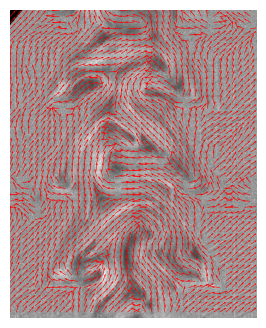

In [154]:
d = fndstruct(1, 10, img)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

In [147]:
d[0,0,:]**2

array([0.40935622, 0.59064378])

## 2 Apply mask

In [42]:
mask = io.imread(r"C:\Users\liuzy\Documents\kymo\mask\A08.tif")

(-0.5, 399.5, 499.5, -0.5)

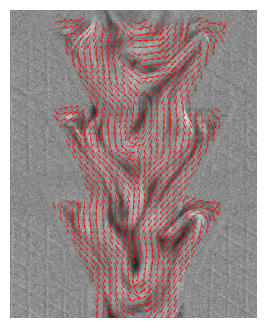

In [63]:
# apply mask to image
d = d.astype(float)
d[~mask.astype("bool"), :] = np.nan
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

## 3 Bending energy

In [11]:
def compute_gradient(field):
    """
    Compute the gradient, divergence andn curl of a 2D field.

    Args:
    field -- the input 2D field, [M x N x 2].

    Returns:
    gradient -- the gradient of the field, [M x N x 2 x 2].
    """
    grad_x = np.gradient(field[:, :, 0])
    grad_y = np.gradient(field[:, :, 1])
    grad = np.array([grad_x, grad_y]).transpose(1, 2, 0, 3)
    div = grad_x[0] + grad_y[1]
    curl = grad_y[0] - grad_x[1]

    return grad, div, curl

In [8]:
def compute_bending_energy(field):
    """
    Compute the bending energy of a 2D field.

    Args:
    field -- the input 2D field, [M x N x 2].

    Returns:
    bending_energy -- the bending energy of the field, [M x N].
    """
    grad, div, curl = compute_gradient(field)
    bending_energy = div**2 + curl**2

    return bending_energy

In [155]:
e = compute_bending_energy(d)

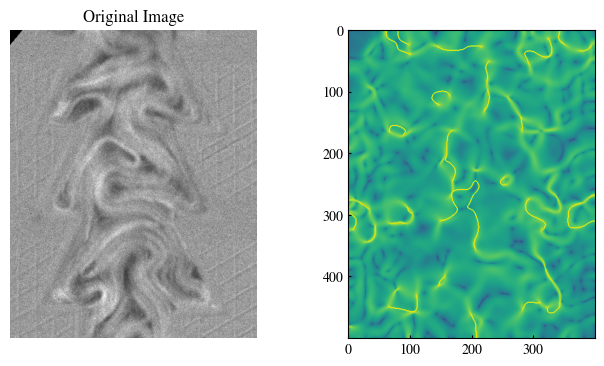

In [156]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.log(e))

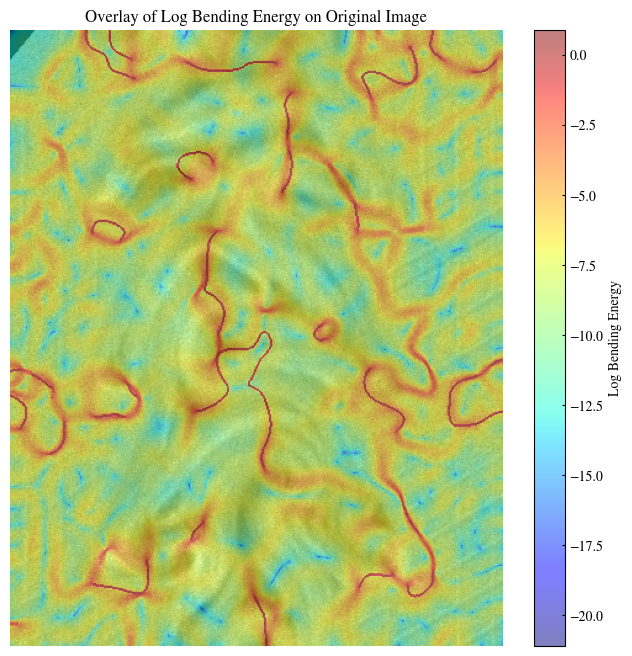

In [157]:
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.imshow(np.log(e), cmap='jet', alpha=0.5)  # Adjust alpha for transparency
plt.colorbar(label='Log Bending Energy')
plt.title('Overlay of Log Bending Energy on Original Image')
plt.axis('off')
plt.show()

In [79]:
# Calculate total bending energy by summing non-NaN values
total_bending_energy = np.nansum(e)
print(f"Total bending energy: {total_bending_energy}")

Total bending energy: 1416.188903623074


## 4 Combine the steps

In [171]:
for channel in ["A", "B", "C"]:
    img = io.imread(rf"C:\Users\liuzy\Documents\kymo\08_{channel}-2100.tif")
    mask = io.imread(rf"C:\Users\liuzy\Documents\kymo\mask\{channel}08.tif")
    d = fndstruct(1, 10, img)
    d = d.astype(float)
    d[~mask.astype("bool"), :] = np.nan
    e = compute_bending_energy(d)
    total_bending_energy = np.nanmean(e)
    print(f"Total bending energy: {total_bending_energy}")

Total bending energy: 0.11133269821274765
Total bending energy: 0.20509602262228138
Total bending energy: 0.20926707344744194


full video analysis

In [220]:
energy = {}
for channel in ["A", "B", "C"]:
    energy[channel] = []
    stack = io.imread(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\crop_channel\08_{channel}.tif")
    mask = io.imread(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\mask\{channel}08.tif")
    for img in stack[:1570:60]:
        d = fndstruct(1, 8, img)
        d = d.astype(float)
        d[~mask.astype("bool"), :] = np.nan
        e = compute_bending_energy(d)
        energy[channel].append(np.nanmean(e))

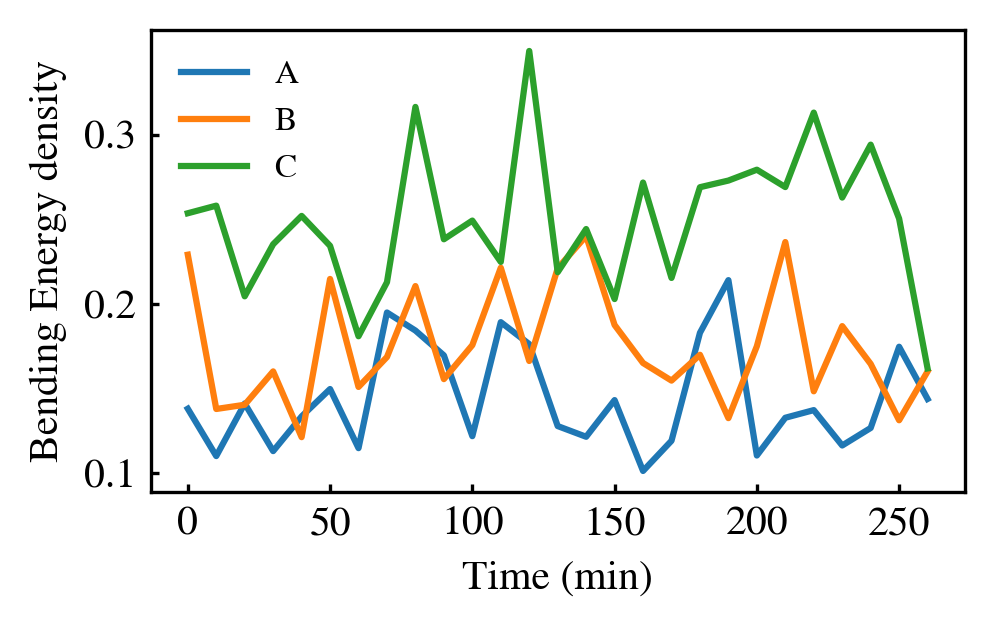

In [221]:
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
for channel in ["A", "B", "C"]:
    ax.plot(np.arange(len(energy[channel]))*0.5*20, energy[channel], label=channel)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Bending Energy density")
ax.legend(frameon=False, fontsize=8)

In [223]:
d.shape

(500, 400, 2)

In [174]:
for channel in ["A", "B", "C"]:
    print(np.array(energy[channel]).mean())

0.14516028472673745
0.16911878737963443
0.2550891509005059


## 5 Plot bending energy with flow rate

I have an argument that the energy penalty is proportional to the square of the flow rate difference from the preferred flow rate $\phi_0$. Here, we can plot the bending energy at all time as a function of flow rate to see the relation. 

I had the assumption that the bending energy is proportional to the square of the difference between flow rate and the preferred flow rate, that is:

$$
E_p \propto (\phi - \phi_0)^2 L.
$$

However, when measuring the bending energy experimentally, I realize that even when $\phi=\phi_0$, $E_p$ is nonzero. So a better model would be 

$$
E_{total} = E_0 + E_p,
$$

where $E_0$ is a constant when $\phi=\phi_0$, and $E_p$ depends on the flow rate. 

Here, we use the mean flow rate in channel A as the $\phi_0$. The mean bending energy in channel A is thus $E_0$. We plot $E_p$ as a function of $\phi-\phi_0$ to see the scaling relation. 

In [2]:
flowrate = pd.read_csv(r"G:\My Drive\Research projects\AN\Data\ASYMMETRIC\08 jun 2023\Flow_rate\08.csv")
angles = {}
for channel in ["A", "B", "C"]:
    angles[channel] = np.load(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field\08_{channel}.npy")
    angles[channel] = np.load(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field\08_{channel}.npy")
    angles[channel] = np.load(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field\08_{channel}.npy")

In [3]:
flowrate["normalizer"] = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=50, axis=0)

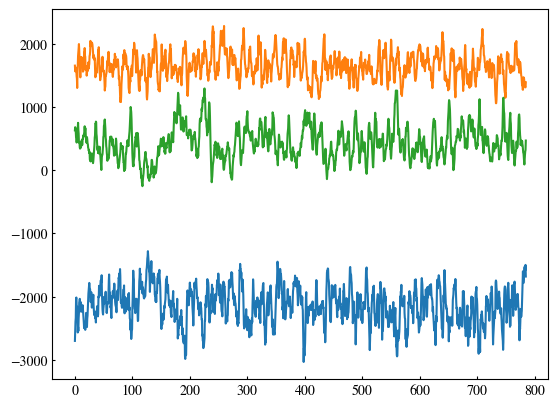

In [4]:
plt.plot(flowrate["t"], flowrate["A"])
plt.plot(flowrate["t"], flowrate["B"])
plt.plot(flowrate["t"], flowrate["C"])

In [65]:
def angle_to_director(angle_8_bit):
    """
    Convert an 8-bit angle image to a director field.

    Args:
    angle_8_bit -- the input 8-bit angle image, [M x N].

    Returns:
    director -- the output director field, [M x N x 2].

    To do: think about the sign of the director.
    """
    angle = angle_8_bit / 255 * np.pi
    director = np.array([np.cos(angle), np.sin(angle)]).transpose(1, 2, 0)

    return director

In [40]:
energy = {}
for channel in ["A", "B", "C"]:
    energy[channel] = []
    mask = io.imread(rf"C:\Users\liuzy\Documents\AN\08 jun 2023\mask\{channel}08.tif")
    for num, angle in enumerate(angles[channel]):
        if num % 100 == 0:
            print(f"frame {num}")
            d = angle_to_director(angle)
            d = d.astype(float)
            d[~mask.astype("bool"), :] = np.nan
            energy[channel].append(np.nanmean(compute_bending_energy(d)))
        

frame 0
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
frame 700
frame 800
frame 900
frame 1000
frame 1100
frame 1200
frame 1300
frame 1400
frame 1500
frame 1600
frame 1700
frame 1800
frame 1900
frame 2000
frame 2100
frame 2200
frame 2300
frame 2400
frame 2500
frame 2600
frame 2700
frame 2800
frame 2900
frame 3000
frame 3100
frame 3200
frame 3300
frame 3400
frame 3500
frame 0
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
frame 700
frame 800
frame 900
frame 1000
frame 1100
frame 1200
frame 1300
frame 1400
frame 1500
frame 1600
frame 1700
frame 1800
frame 1900
frame 2000
frame 2100
frame 2200
frame 2300
frame 2400
frame 2500
frame 2600
frame 2700
frame 2800
frame 2900
frame 3000
frame 3100
frame 3200
frame 3300
frame 3400
frame 3500
frame 0
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
frame 700
frame 800
frame 900
frame 1000
frame 1100
frame 1200
frame 1300
frame 1400
frame 1500
frame 1600
frame 1700
frame 1800
frame 1900
frame 2000
frame 2100
fr

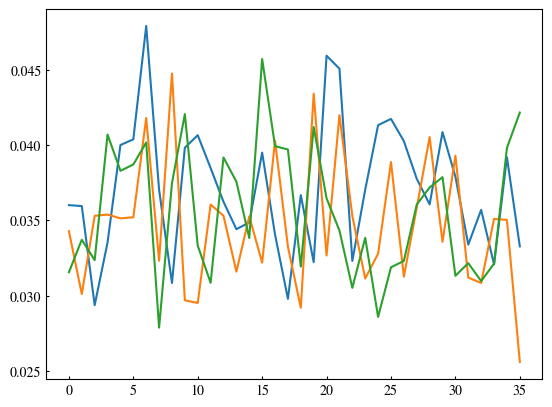

In [41]:
for channel in ["A", "B", "C"]:
    plt.plot(energy[channel], label=channel)


In [24]:
d.shape

(500, 400, 2)

[]

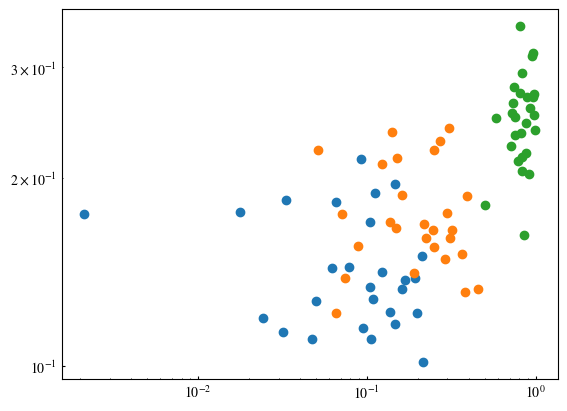

In [212]:
for channel in ["A", "B", "C"]:
    plt.scatter(np.abs(np.abs(flow[channel])-flow["normalizer"])/flow["normalizer"], energy[channel])
# plt.xlim([0, 3000])
# plt.ylim([0, 0.34])
plt.loglog()

## 6 Convert director to angle

Saving director requires [M x N x F x 2] matrix of floats, which can take up a lot of storage space (8 times of the images). To reduce it, we convert the director field to angle field and use a 8-bit number to represent the angle, i.e. angle8 = angle/pi*255, where angle is in [0, pi). 

In [260]:
def director_to_angle(director_field):
    """
    Convert a director field to an angle field.

    Args:
    director_field -- the input director field, [M x N x 2].

    Returns:
    angle_field -- the angle field, [M x N].
    """
    angle_field = np.arctan(director_field[:, :, 1] / director_field[:, :, 0]) + np.pi/2
    angle_field_8bit = (angle_field / np.pi * 255).astype(np.uint8)
    return angle_field_8bit

In [261]:
a = director_to_angle(d)

(-0.5, 399.5, 499.5, -0.5)

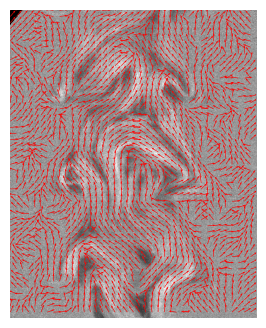

In [246]:
d = fndstruct(1, 10, img)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

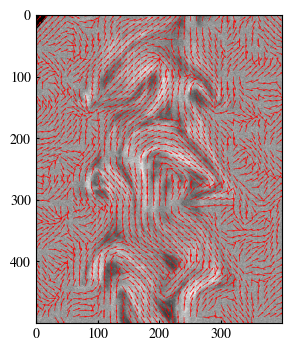

In [263]:
# reconstruct the director field
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
plt.quiver(X, Y, np.cos(a[::step, ::step]/255*np.pi-np.pi/2), np.sin(a[::step, ::step]/255*np.pi-np.pi/2), color='r', scale=30)

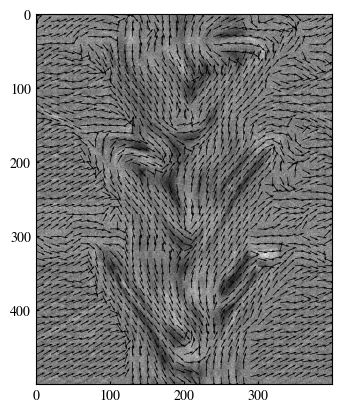

In [273]:
folder = r"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field"
df = np.load(os.path.join(folder, "07_A.npy"))
img = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\crop_channel\07_A.tif")[0]
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, np.cos(df[0, ::10, ::10]/255*np.pi-np.pi/2), np.sin(df[0, ::10, ::10]/255*np.pi-np.pi/2), scale=30)

## Appendix A. Verify director field

In [59]:
img = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\crop_channel\08_A.tif")[0]
angle = np.load(r"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field\08_A.npy")[0]
mask = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\mask\A08.tif")

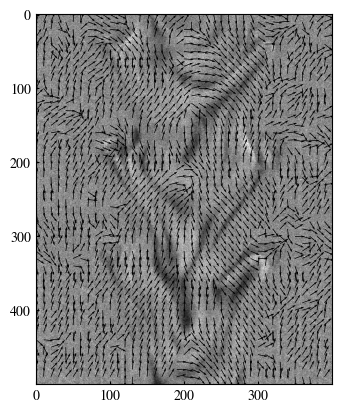

In [62]:
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
d = angle_to_director(angle)
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], scale=30)

In [53]:
e = compute_bending_energy(d)
e[~mask.astype("bool")] = np.nan

C:\Users\liuzy\AppData\Local\Temp\ipykernel_28780\1418451294.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(e), cmap='jet', alpha=0.5)  # Adjust alpha for transparency


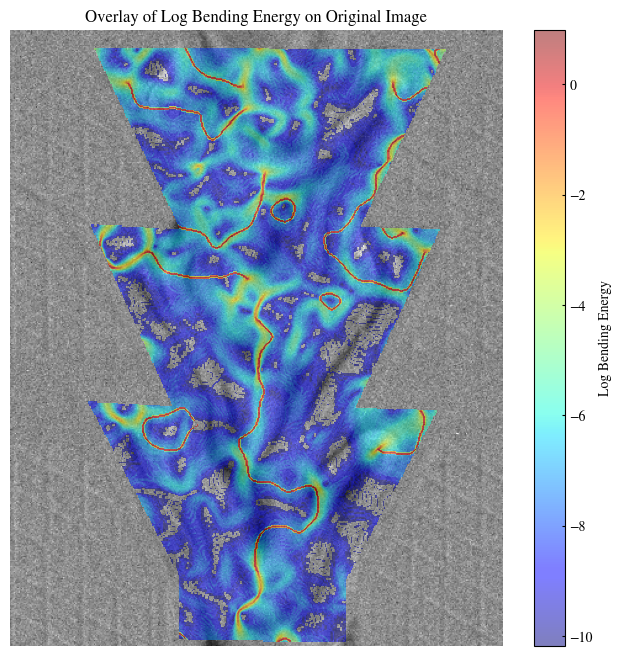

In [54]:
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.imshow(np.log(e), cmap='jet', alpha=0.5)  # Adjust alpha for transparency
plt.colorbar(label='Log Bending Energy')
plt.title('Overlay of Log Bending Energy on Original Image')
plt.axis('off')
plt.show()